# Elo Score Calculation

In [1]:
import re
import os
from collections import defaultdict

In [2]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (20,8)

## Summary

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Importing Data

In [5]:
xls = pd.ExcelFile("./data/Home_Cage_Behaviors_Data.xlsx")
sheets = xls.sheet_names

In [6]:
sheets

['Elo_Score_Data', 'CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

In [24]:
tube_test_df = pd.read_excel("./data/Tube_Test.xlsx", sheet_name=sheets[1], header=1)

In [25]:
tube_test_df.head()

,RUNNER,DATE,MATCH,WINNER,LOSER,NOTES
0,Ezra,2022-07-11,1vs2,2,1,NaN
1,NaN,NaT,2vs3,2,3,NaN
2,NaN,NaT,3vs4,3,4,NaN
3,NaN,NaT,1vs3,3,1,NaN
4,NaN,NaT,2vs4,2,4,NaN


In [26]:
copy_tube_test_df = tube_test_df.copy()

# Adding the session numbers

- Each new session has the date as a row, so we will get the index of all the rows with dates



In [27]:
tube_test_df.dropna(axis=0, subset="DATE")

,RUNNER,DATE,MATCH,WINNER,LOSER,NOTES
0,Ezra,2022-07-11,1vs2,2,1,NaN
6,Catalina,2022-07-12,3vs2,2,3,NaN
12,Nancy,2022-07-13,4vs3,3,4,NaN
18,Ezra,2022-07-14,2vs3,2,3,NaN
24,Erika,2022-07-15,1vs4,1,4,NaN
30,Naeliz,2022-07-18,1vs2,1,2,* started at 1pm
36,Catalina,2022-07-20,3vs2,2,3,NaN
42,Isabel,2022-07-23,4vs3,3,4,NaN
48,Jocelyn,2022-07-24,1vs4,1,4,"Tube testing began before reward training, as ..."
54,Jocelyn,2022-07-25,2vs3,2,3,NaN


In [28]:
tube_test_df.dropna(axis=0, subset="DATE").index

Int64Index([0, 6, 12, 18, 24, 30, 36, 42, 48, 54], dtype='int64')

- Adding a new row that is the sessin number and leaving it blank
    - We will add the session number to the rows with dates

In [29]:
tube_test_df["session_number"] = np.nan

In [30]:
session_number = 1
for index in tube_test_df.dropna(axis=0, subset="DATE").index:
    tube_test_df.at[index, "session_number"] = session_number
    session_number += 1

In [31]:
tube_test_df.head()

,RUNNER,DATE,MATCH,WINNER,LOSER,NOTES,session_number
0,Ezra,2022-07-11,1vs2,2,1,NaN,1.0
1,NaN,NaT,2vs3,2,3,NaN,NaN
2,NaN,NaT,3vs4,3,4,NaN,NaN
3,NaN,NaT,1vs3,3,1,NaN,NaN
4,NaN,NaT,2vs4,2,4,NaN,NaN


- Filling in the empty cells with the previous row's values

In [32]:
tube_test_df = tube_test_df.fillna(method='ffill')

In [33]:
tube_test_df.head()

,RUNNER,DATE,MATCH,WINNER,LOSER,NOTES,session_number
0,Ezra,2022-07-11,1vs2,2,1,NaN,1.0
1,Ezra,2022-07-11,2vs3,2,3,NaN,1.0
2,Ezra,2022-07-11,3vs4,3,4,NaN,1.0
3,Ezra,2022-07-11,1vs3,3,1,NaN,1.0
4,Ezra,2022-07-11,2vs4,2,4,NaN,1.0


- Making another column for vertical lines for plotting

In [34]:
tube_test_df["session_number_plotting"] = np.nan

In [38]:
session_number = 1
for index in copy_tube_test_df.dropna(axis=0, subset="DATE").index:
    tube_test_df.at[index, "session_number_plotting"] = session_number
    session_number += 1

## Getting a list of all the animals

- Because each cell does not contain the ID of all the animals that were competing, we will make a new column with both ID's

In [39]:
def get_all_animal_ids(animal_string):
    """
    Converts a string that contains the ID of animals, and only gets the IDs. 
    This usually removes extra characters that were added. (i.e. "1.1 v 2.2" to ("1.1", "2.2"))

    Args:
        animal_string(str): This is the first param.

    Returns:
        tuple: Of IDs of animals as strings
    """
    # Splitting by space so that we have a list of just the words
    all_words = animal_string.split()
    # Removing all words that are not numbers
    all_numbers = [num for num in all_words if re.match(r'^-?\d+(?:\.\d+)$', num)]
    return tuple(all_numbers)


In [40]:
print(get_all_animal_ids("1.1 v 2.3"))

('1.1', '2.3')


## Elo Score Calculation

In [42]:
def calculate_elo_score(subject_elo_score, agent_elo_score, k_factor=20, score=1, number_of_decimals=None):
    """
    Calculates the Elo score of a given subject given it's original score, it's opponent, 
    the K-Factor, and whether or not it has won or not. 
    The calculation is based on: https://www.omnicalculator.com/sports/elo

    Args:
        subject_elo_score(float): The original Elo score for the subject
        agent_elo_score(float): The original Elo score for the agent
        k_factor(int): k-factor, or development coefficient. 
            - It usually takes values between 10 and 40, depending on player's strength 
        score(int): the actual outcome of the game. 
            - In chess, a win counts as 1 point, a draw is equal to 0.5, and a lose gives 0.
        number_of_decimals(int): Number of decimals to round to
        
    Returns:
        int: Updated Elo score of the subject
    """
    # Calculating the Elo score
    rating_difference = agent_elo_score - subject_elo_score
    expected_score = 1 / (1 + 10 ** (rating_difference / 400))
    new_elo_score = subject_elo_score + k_factor * (score - expected_score)
    # Rounding to `number_of_decimals`
    return round(new_elo_score, number_of_decimals)

In [43]:
calculate_elo_score(subject_elo_score=1500, agent_elo_score=500, score=0)

1480

## Calculate all the Elo scores for this cage

In [18]:
cage_1_df.columns

Index(['cage', 'animal', '26-Apr', '27-Apr', '28-Apr', '29-Apr', '2-May',
       '5-May', '10-May', '11-May', '12-May', '13-May', '20-May',
       'all_animals'],
      dtype='object')

In [46]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))

# Keeping track of the number of matches
id_to_match_number = defaultdict(lambda:1)
total_match_number = 1
for index, row in tube_test_df.iterrows():
    # Checking if there is an Nan or not
    if row["WINNER"] == "nan":
        continue
    else:            
        winner_id = row["WINNER"]
    date = row["DATE"]
    # Getting the ID of the loser subject
    loser_id = row["LOSER"]
    # Getting the current Elo Score
    current_winner_rating = id_to_elo_score[winner_id] 
    current_loser_rating = id_to_elo_score[loser_id] 
    # Calculating Elo score            
    id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=1, number_of_decimals=1)
    id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=0, number_of_decimals=1)

    # Saving all the data for the winner
    winner_index = next(all_indexes)
    index_to_elo_score_and_meta_data[winner_index]["date"] = date
    index_to_elo_score_and_meta_data[winner_index]["match_number"] = id_to_match_number[str(date)]
    index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
    index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
    index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
    index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
    index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = 1
    index_to_elo_score_and_meta_data[winner_index]["session_number"] = row["session_number"]
    index_to_elo_score_and_meta_data[winner_index]["session_number_plotting"] = row["session_number_plotting"]

    index_to_elo_score_and_meta_data[winner_index]["total_match_number"] = total_match_number



    # Saving all the data for the loser
    loser_index = next(all_indexes)
    index_to_elo_score_and_meta_data[loser_index]["date"] = date
    index_to_elo_score_and_meta_data[loser_index]["match_number"] = id_to_match_number[str(date)]
    index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
    index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
    index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
    index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
    index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = 0
    index_to_elo_score_and_meta_data[loser_index]["session_number"] = row["session_number"]
    index_to_elo_score_and_meta_data[loser_index]["session_number_plotting"] = row["session_number_plotting"]

    index_to_elo_score_and_meta_data[loser_index]["total_match_number"] = total_match_number


    total_match_number += 1
    id_to_match_number[str(date)] += 1
    

In [47]:
id_to_elo_score

defaultdict(<function __main__.<lambda>()>,
            {2: 1101.7, 1: 1070.8, 3: 1017.2, 4: 810.3})

In [48]:
index_to_elo_score_and_meta_data[0]

{'date': Timestamp('2022-07-11 00:00:00'),
 'match_number': 1,
 'subject_id': 2,
 'agent_id': 1,
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1,
 'session_number': 1.0,
 'session_number_plotting': 1.0,
 'total_match_number': 1}

In [49]:
elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [50]:
elo_score_df.head(n=25)

,date,match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,session_number,session_number_plotting,total_match_number
0,2022-07-11,1,2,1,1000.0,1010.0,1,1.0,1.0,1
1,2022-07-11,1,1,2,1000.0,990.0,0,1.0,1.0,1
2,2022-07-11,2,2,3,1010.0,1019.7,1,1.0,NaN,2
3,2022-07-11,2,3,2,1000.0,990.3,0,1.0,NaN,2
4,2022-07-11,3,3,4,990.3,1000.6,1,1.0,NaN,3
5,2022-07-11,3,4,3,1000.0,989.7,0,1.0,NaN,3
6,2022-07-11,4,3,1,1000.6,1010.3,1,1.0,NaN,4
7,2022-07-11,4,1,3,990.0,980.3,0,1.0,NaN,4
8,2022-07-11,5,2,4,1019.7,1028.8,1,1.0,NaN,5
9,2022-07-11,5,4,2,989.7,980.6,0,1.0,NaN,5


# Plotting the Elo Score

## Making the Dates into Numbers

## Plotting the Scores

In [57]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (20,8)

(700.0, 1300.0)

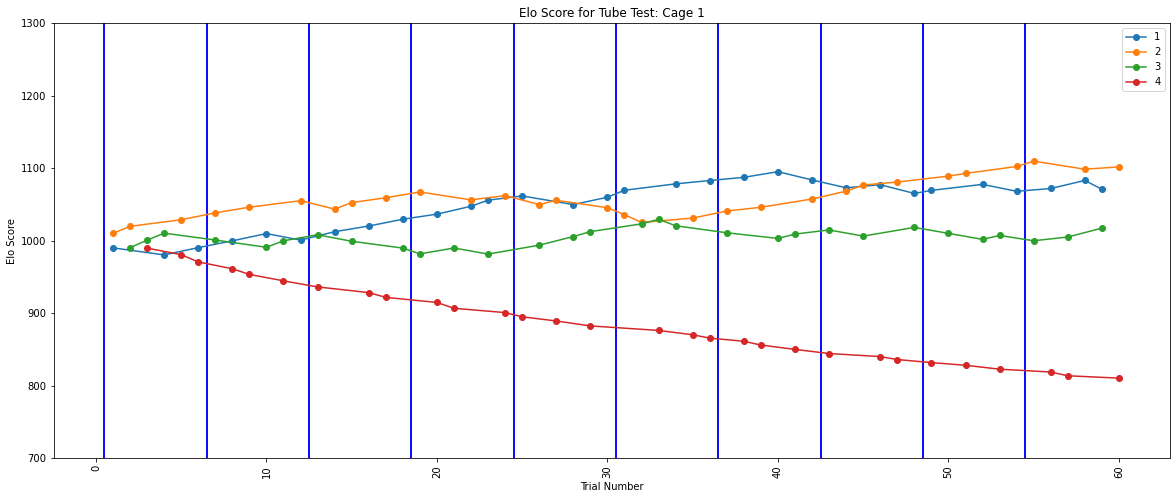

In [60]:
fig, ax = plt.subplots()



lines = []
for index, row in elo_score_df.dropna(subset=["session_number_plotting"]).iterrows():
#     lines.append(plt.axvline(x = row["total_match_number"] - 0.5, color = 'b', label=row["session_number_plotting"]))
    plt.vlines(x=[row["total_match_number"] - 0.5], ymin=700, ymax=1300, colors='b')

for subject in sorted(elo_score_df["subject_id"].unique()):
    # Getting all the rows with the current subject
    subject_df = elo_score_df[elo_score_df["subject_id"] == subject]
    # Making the dates into days after the first session by subtracting all the dates by the first date
    plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

# Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
# Labeling the X/Y Axis and the title
ax.set_xlabel("Trial Number")
ax.set_ylabel("Elo Score")
ax.set_title("Elo Score for Tube Test: Cage {}".format(1))
# To show the legend
ax.legend()
plt.xticks(rotation=90)
plt.ylim(700, 1300) 

# file_name = "home_cage_elo_score_cage_{}_date_{}_{}.png".format(1, earliest_date, latest_date)
#     plt.savefig(os.path.join("./proc/plots/home_cage", file_name))


In [ ]:
# Plotting for each cage
fig, ax = plt.subplots()

# Plotting a line for each subject
for subject in elo_score_df["subject_id"].unique():
    # Getting all the rows with the current subject
    subject_df = elo_score_df[elo_score_df["subject_id"] == subject]
    # Making the dates into days after the first session by subtracting all the dates by the first date
    ax.plot(subject_df["date_time"], subject_df["updated_elo_score"], '-o', label=subject)



# Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
# Labeling the X/Y Axis and the title
ax.set_xlabel("Date")
ax.set_ylabel("Elo Score")
ax.set_title("Elo Score for Tube Testing: Cage {}".format(cage))
# To show the legend
ax.legend()
plt.xticks(rotation=90)
plt.ylim(700, 1300) 
# file_name = "tube_testing_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
# plt.savefig(os.path.join("./proc/plots/tube_testing", file_name))


In [49]:
all_cages = "_".join(elo_score_df["cage"].unique())

In [50]:
all_cages

'1_2_3_4'

In [51]:
elo_score_df.to_csv("./proc/tube_test_elo_score_cage_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date))
# elo_score_df.to_excel("./proc/id_to_date_elo_score.xlsx")

# Replotting the Plots

- Calculating the match number so that it's the same match number line for all

In [52]:
tube_test_df

,cage,animal,2022/04/26,2022/04/27,2022/04/28,2022/04/29,2022/05/02,2022/05/05,2022/05/10,2022/05/11,2022/05/12,2022/05/13,2022/05/20,all_animals
0,1,1.1 v 2.2,1.1,1.1,2.2,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,"(1.1, 2.2)"
1,1,2.2 v 2.3,2.3,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,"(2.2, 2.3)"
2,1,2.3 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,"(2.3, 1.4)"
3,1,1.4 v 1.1,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,"(1.4, 1.1)"
4,1,2.2 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,"(2.2, 1.4)"
5,1,1.1 v 2.3,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,"(1.1, 2.3)"
6,2,2.1 v 1.2,2.1,2.1,2.1,2.1,2.1,2.1,2.1,2.1,2.1,2.1,2.1,"(2.1, 1.2)"
7,2,1.2 v 1.3,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,"(1.2, 1.3)"
8,2,1.3 v 2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,"(1.3, 2.4)"
9,2,2.4 v 2.1,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.1,2.1,2.1,"(2.4, 2.1)"


In [53]:
index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))
for column in tube_test_df:
    if column not in ['cage', 'animal', 'all_animals']:
        # Keeping track of the number of matches
        cage_to_match_number = defaultdict(lambda:1)


# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))
match_number = 0
cage_to_match_number = defaultdict(lambda:1)

for column in tube_test_df:
    if column not in ['cage', 'animal', 'all_animals']:
        # Keeping track of the number of matches
        for index, row in tube_test_df.iterrows():
            # Checking if there is an Nan or not
            if row[column] == "nan":
                continue
            else:            
                winner_id = row[column]

            # Getting the ID of the loser subject
            loser_id = list(set(row["all_animals"]) - set([winner_id]))
            loser_id = loser_id[0]
            # Getting the current Elo Score
            current_winner_rating = id_to_elo_score[winner_id] 
            current_loser_rating = id_to_elo_score[loser_id] 
            # Calculating Elo score            
            id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=1, number_of_decimals=1)
            id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=0, number_of_decimals=1)
            
            # Saving all the data for the winner
            winner_index = next(all_indexes)
            index_to_elo_score_and_meta_data[winner_index]["date"] = column
            index_to_elo_score_and_meta_data[winner_index]["match_number"] = cage_to_match_number[row["cage"]]
            index_to_elo_score_and_meta_data[winner_index]["cage"] = row["cage"]
            index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
            index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
            index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
            index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
            index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = 1
            
            
            # Saving all the data for the loser
            loser_index = next(all_indexes)
            index_to_elo_score_and_meta_data[loser_index]["date"] = column
            index_to_elo_score_and_meta_data[loser_index]["match_number"] = cage_to_match_number[row["cage"]]
            index_to_elo_score_and_meta_data[loser_index]["cage"] = row["cage"]
            index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
            index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
            index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
            index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
            index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = 0
            
            cage_to_match_number[row["cage"]] += 1    

In [54]:
elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [55]:
elo_score_df.head(n=25)

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss
0,2022/04/26,1,1,1.1,2.2,1000.0,1010.0,1
1,2022/04/26,1,1,2.2,1.1,1000.0,990.0,0
2,2022/04/26,2,1,2.3,2.2,1000.0,1009.7,1
3,2022/04/26,2,1,2.2,2.3,990.0,980.3,0
4,2022/04/26,3,1,1.4,2.3,1000.0,1010.3,1
5,2022/04/26,3,1,2.3,1.4,1009.7,999.4,0
6,2022/04/26,4,1,1.4,1.1,1010.3,1020.3,1
7,2022/04/26,4,1,1.1,1.4,1010.0,1000.0,0
8,2022/04/26,5,1,1.4,2.2,1020.3,1029.2,1
9,2022/04/26,5,1,2.2,1.4,980.3,971.4,0


In [56]:
elo_score_df.groupby(["subject_id"]).count()

,date,match_number,cage,agent_id,original_elo_score,updated_elo_score,win_draw_loss
subject_id,,,,,,,
1.1,33,33,33,33,33,33,33
1.2,33,33,33,33,33,33,33
1.3,33,33,33,33,33,33,33
1.4,33,33,33,33,33,33,33
2.1,33,33,33,33,33,33,33
2.2,33,33,33,33,33,33,33
2.3,33,33,33,33,33,33,33
2.4,33,33,33,33,33,33,33
3.1,33,33,33,33,33,33,33


In [57]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (20,8)

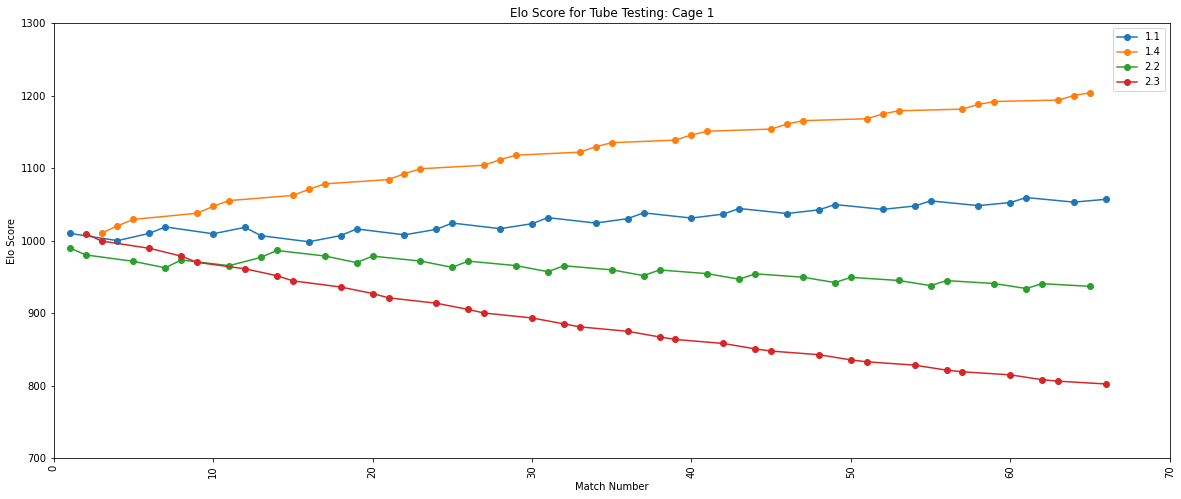

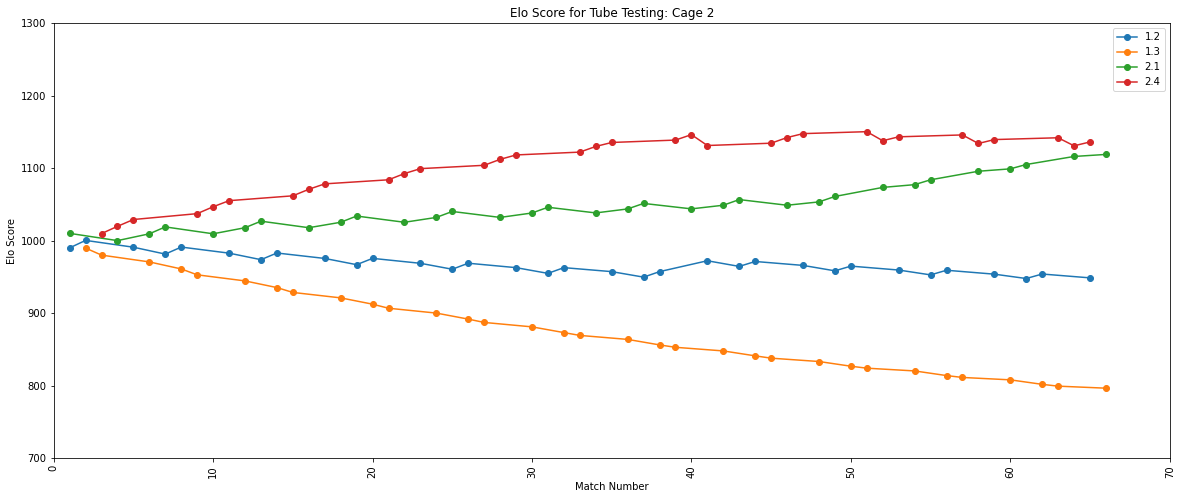

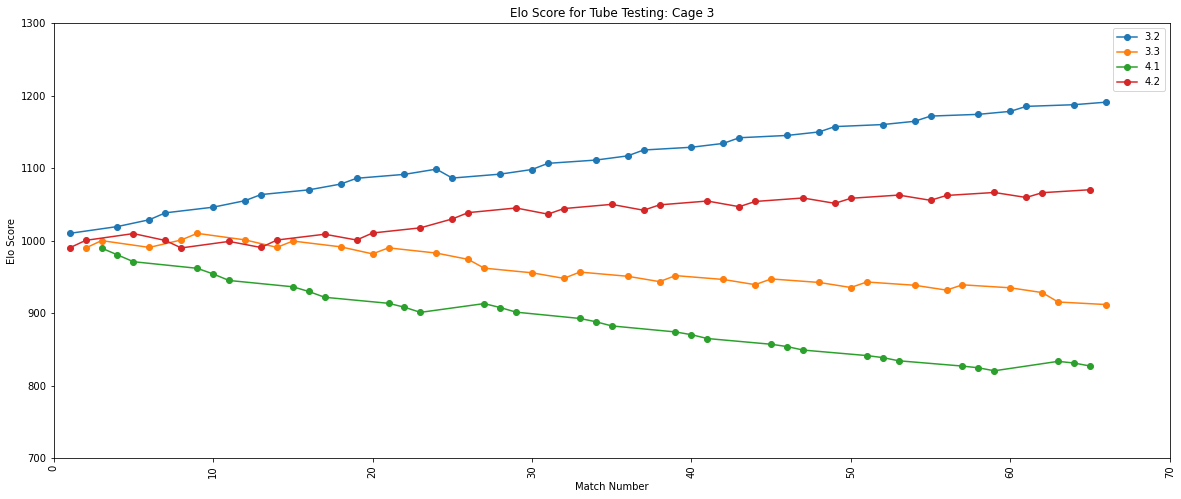

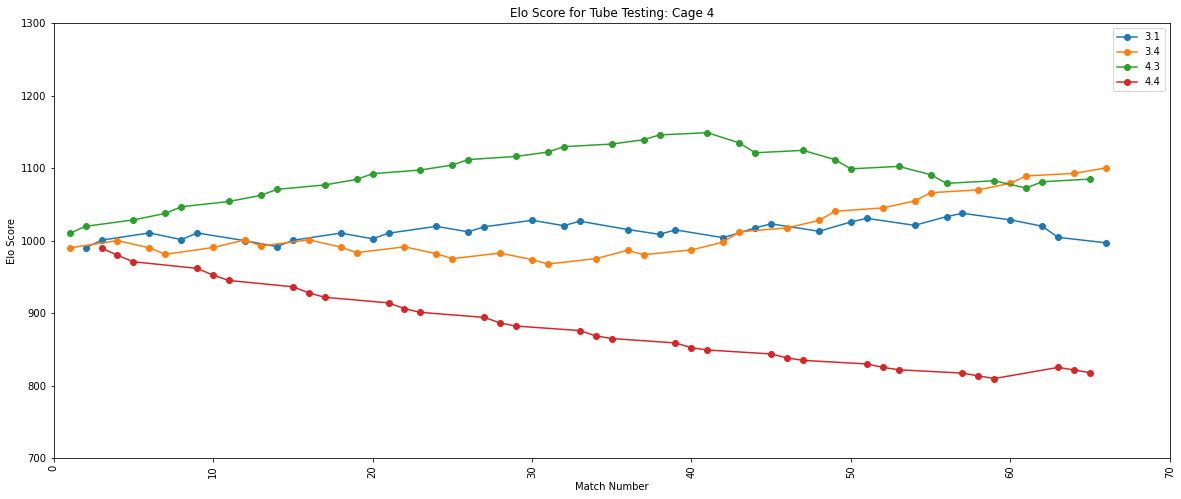

In [60]:
# Plotting for each cage
for cage in elo_score_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = elo_score_df[elo_score_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in sorted(cage_df["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["match_number"], subject_df["updated_elo_score"], '-o', label=subject)
    
    
    
    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Match Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Tube Testing: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(700, 1300)
    plt.xlim(0, 70)
    file_name = "tube_testing_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join("./proc/plots/tube_testing", file_name))
